# Pneumonia Classification using Active Learning

**Author:** Sindhu T P<br>
**Date created:** 2/28/2025<br>
**Description:** Demonstrating the advantages of active learning through Pneumonia classification.

## Introduction

With the growth of data-centric Machine Learning, Active Learning has grown in popularity
amongst businesses and researchers. Active Learning seeks to progressively
train ML models so that the resultant model requires lesser amount of training data to
achieve competitive scores.

The structure of an Active Learning pipeline involves a classifier and an oracle. The
oracle is an annotator that cleans, selects, labels the data, and feeds it to the model
when required. The oracle is a trained individual or a group of individuals that
ensure consistency in labeling of new data.

The process starts with annotating a small subset of the full dataset and training an
initial model. The best model checkpoint is saved and then tested on a balanced test
set. The test set must be carefully sampled because the full training process will be
dependent on it. Once we have the initial evaluation scores, the oracle is tasked with
labeling more samples; the number of data points to be sampled is usually determined by
the business requirements. After that, the newly sampled data is added to the training
set, and the training procedure repeats. This cycle continues until either an
acceptable score is reached or some other business metric is met.

This project provides a basic demonstration of how Active Learning works by
demonstrating a ratio-based (least confidence) sampling strategy that results in lower
overall false positive and negative rates when compared to a model trained on the entire
dataset. This sampling falls under the domain of *uncertainty sampling*, in which new
datasets are sampled based on the uncertainty that the model outputs for the
corresponding label. In our example, we compare our model's false positive and false
negative rates and annotate the new data based on their ratio.

Some other sampling techniques include:

1. [Committee sampling](https://www.researchgate.net/publication/51909346_Committee-Based_Sample_Selection_for_Probabilistic_Classifiers):
Using multiple models to vote for the best data points to be sampled
2. [Entropy reduction](https://www.researchgate.net/publication/51909346_Committee-Based_Sample_Selection_for_Probabilistic_Classifiers):
Sampling according to an entropy threshold, selecting more of the samples that produce the highest entropy score.
3. [Minimum margin based sampling](https://arxiv.org/abs/1906.00025v1):
Selects data points closest to the decision boundary

## Importing required libraries

In [ ]:
%pip install tensorflow-datasets

In [ ]:
%pip install tfds-nightly

## MedMNIST Pneumonia Dataset
The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. The source training set is split with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384–2,916) × (127–2,713). The images are center-cropped with a window size of length of the short edge and resized into 1 × 28 × 28.

- Homepage: https://medmnist.com//
- Source code: tfds.datasets.pneumonia_mnist.Builder
- Versions:
  - 1.0.0 (default): Initial release.
  - Download size: Unknown size
- Dataset size: 3.66 MiB
- Auto-cached (documentation): Yes

**Splits:**
- Split	Examples
- 'test'	624
- 'train'	4,708
- 'val'	524

**Feature structure:**<br>
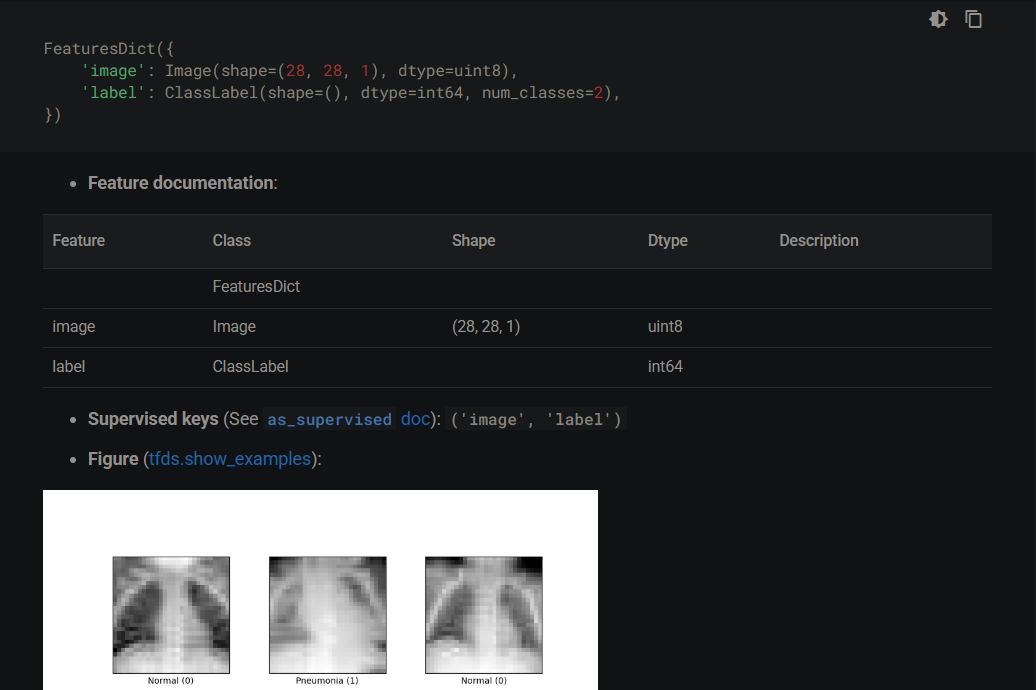

**Citation:**<br>
@article{yang2023medmnist,
  title={Medmnist v2-a large-scale lightweight benchmark for 2d and 3d biomedical image classification},
  author={Yang, Jiancheng and Shi, Rui and Wei, Donglai and Liu, Zequan and Zhao, Lin and Ke, Bilian and Pfister, Hanspeter and Ni, Bingbing},
  journal={Scientific Data},
  volume={10},
  number={1},
  pages={41},
  year={2023},
  publisher={Nature Publishing Group UK London}
}

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"  # @param ["tensorflow", "jax", "torch"]
import keras
from keras import ops
from keras import layers
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import string

tfds.disable_progress_bar()

## Loading and preprocessing the data

In [ ]:
tfds.list_builders()

In [2]:
ds_train = tfds.load(
    name="pneumonia_mnist",
    split="train",
    as_supervised=True,
    batch_size=-1,
    shuffle_files=False
)
ds_test = tfds.load("pneumonia_mnist",split="test",as_supervised=True,batch_size=-1,shuffle_files=False)

ds_val =  tfds.load("pneumonia_mnist",split="val",as_supervised=True,batch_size=-1,shuffle_files=False)

In [3]:
type(ds_train)

tuple

In [4]:
import numpy as np

x_train, y_train = ds_train
x_test, y_test = ds_test

y_train = np.array(y_train)
y_test = np.array(y_test)

print("First 10 labels in train set: ", y_train[:10])

First 10 labels in train set:  [0 1 0 1 0 1 0 1 1 1]


In [5]:
x_val, y_val = ds_val
y_val = np.array(y_val) 
x_val.shape

TensorShape([524, 28, 28, 1])

In [6]:
x_train.shape

TensorShape([4708, 28, 28, 1])

## Exploratory Data Analysis

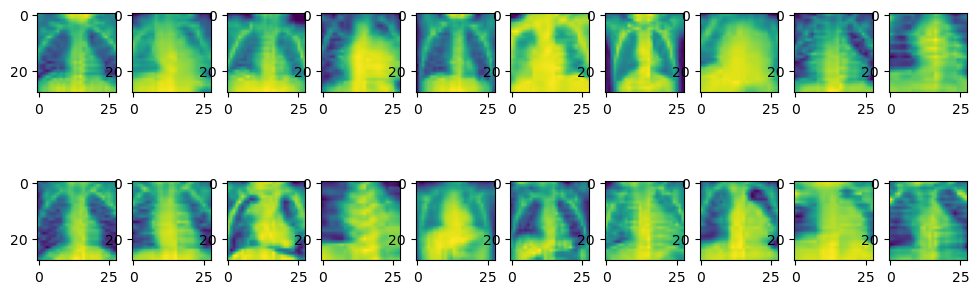

<Figure size 640x480 with 0 Axes>

In [67]:
plt.figure(figsize=(12, 4))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(x_train[i]) #, cmap='gray'
plt.show()
plt.tight_layout()

## Class Distribution

In [7]:
import pandas as pd
# Load the dataset
ds, info = tfds.load('pneumonia_mnist', split='train', with_info=True)

# Convert the dataset to a DataFrame
df = tfds.as_dataframe(ds, info)

# Display the first few rows of the DataFrame
print(df.head())

                                               image  label
0  [[[141], [139], [123], [109], [110], [115], [1...      0
1  [[[55], [59], [68], [79], [86], [92], [104], [...      1
2  [[[19], [30], [38], [36], [27], [16], [5], [0]...      0
3  [[[76], [57], [60], [57], [41], [60], [85], [7...      1
4  [[[59], [66], [105], [137], [131], [118], [104...      0


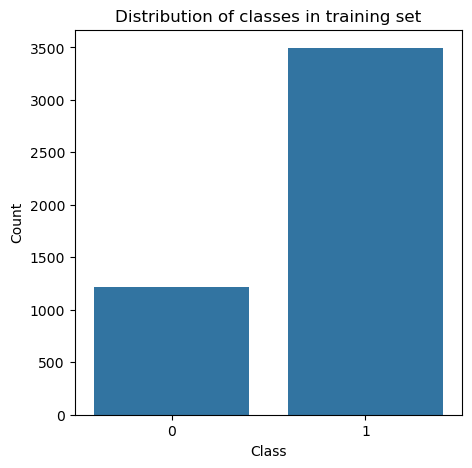

In [18]:
import seaborn as sns
plt.figure(figsize=(5,5))
sns.countplot(x='label', data=df)
plt.title("Distribution of classes in training set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


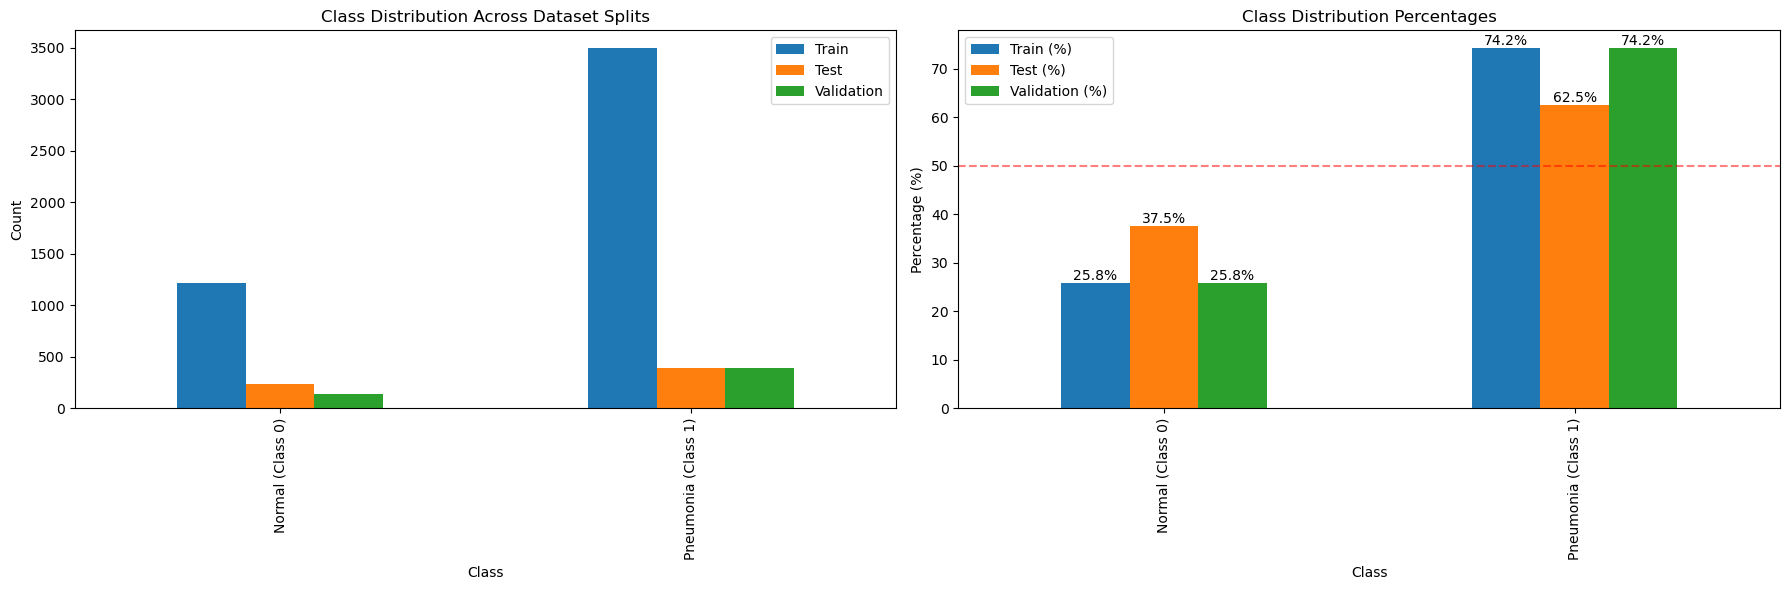


Class Distribution Summary:
                     Train  Test  Validation
Normal (Class 0)      1214   234         135
Pneumonia (Class 1)   3494   390         389

Percentage Distribution:
                     Train (%)  Test (%)  Validation (%)
Normal (Class 0)     25.785896      37.5       25.763359
Pneumonia (Class 1)  74.214104      62.5       74.236641

Imbalance Ratios (Majority:Minority):
Train: 2.88:1
Test: 1.67:1
Validation: 2.88:1

The dataset is imbalanced with Pneumonia being the majority class.
This imbalance could affect model training in the following ways:
1. Model may be biased toward the majority class
2. Performance metrics like accuracy could be misleading
3. Active learning strategies will be particularly useful for handling this imbalance


In [ ]:
# Perform analysis of class imbalance in the pneumonia dataset

# Calculate class distribution in all splits
train_class_counts = np.bincount(y_train)
test_class_counts = np.bincount(y_test)
val_class_counts = np.bincount(y_val)

# Create a DataFrame to hold all counts
class_distribution = pd.DataFrame({
    'Train': train_class_counts,
    'Test': test_class_counts,
    'Validation': val_class_counts
})
class_distribution.index = ['Normal (Class 0)', 'Pneumonia (Class 1)']

# Calculate percentages
train_total = train_class_counts.sum()
test_total = test_class_counts.sum()
val_total = val_class_counts.sum()

train_percentages = train_class_counts / train_total * 100
test_percentages = test_class_counts / test_total * 100
val_percentages = val_class_counts / val_total * 100

# Create a DataFrame for percentages
percentage_distribution = pd.DataFrame({
    'Train (%)': train_percentages,
    'Test (%)': test_percentages,
    'Validation (%)': val_percentages
})
percentage_distribution.index = ['Normal (Class 0)', 'Pneumonia (Class 1)']

# Plot the class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot counts
class_distribution.plot(kind='bar', ax=ax1)
ax1.set_title('Class Distribution Across Dataset Splits')
ax1.set_ylabel('Count')
ax1.set_xlabel('Class')

# Plot percentages
percentage_distribution.plot(kind='bar', ax=ax2)
ax2.set_title('Class Distribution Percentages')
ax2.set_ylabel('Percentage (%)')
ax2.set_xlabel('Class')

# Add a horizontal line at 50% for reference
ax2.axhline(y=50, color='r', linestyle='--', alpha=0.5)

# Add annotations for percentages
for p in ax2.patches:
    ax2.annotate(f"{p.get_height():.1f}%", 
                (p.get_x() + p.get_width()/2, p.get_height()), 
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Calculate imbalance ratio (majority/minority)
imbalance_ratios = {
    'Train': max(train_percentages) / min(train_percentages),
    'Test': max(test_percentages) / min(test_percentages),
    'Validation': max(val_percentages) / min(val_percentages)
}

print("\nClass Distribution Summary:")
print(class_distribution)
print("\nPercentage Distribution:")
print(percentage_distribution)
print("\nImbalance Ratios (Majority:Minority):")
for split, ratio in imbalance_ratios.items():
    print(f"{split}: {ratio:.2f}:1")

# Report on implications for model training
majority_class = 'Pneumonia' if train_class_counts[1] > train_class_counts[0] else 'Normal'
print(f"\nThe dataset is imbalanced with {majority_class} being the majority class.")
print("This imbalance could affect model training in the following ways:")
print("1. Model may be biased toward the majority class")
print("2. Performance metrics like accuracy could be misleading")
print("3. Active learning strategies will be particularly useful for handling this imbalance")

### Normalization and Sampling

In [161]:
x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0

In [69]:
x_test.shape

(624, 28, 28, 1)

In [162]:
print(x_test[y_test == 1].shape)
x_test[y_test == 0].shape

(390, 28, 28, 1)


(234, 28, 28, 1)

In [163]:

# Seperating positive and negative examples for manual train-val split

x_train_pos = x_train[y_train == 1]
x_train_neg = x_train[y_train == 0]
y_train_pos = y_train[y_train == 1]
y_train_neg = y_train[y_train == 0]

print(x_train_neg.shape)
print(x_train_pos.shape)

(1214, 28, 28, 1)
(3494, 28, 28, 1)


In [164]:
x_train_pos = x_train_pos[:1000]
x_train_neg = x_train_neg[:1000]
y_train_pos = y_train_pos[:1000]
y_train_neg = y_train_neg[:1000]

In [120]:
print(x_train_neg.shape)
print(x_train_pos.shape)

(1000, 28, 28, 1)
(1000, 28, 28, 1)


In [166]:
# 50 examples for each class
val_split = 50
train_split = 50

x_val = np.concatenate((x_train_pos[:val_split],x_train_neg[:val_split]),axis=0)
y_val = np.concatenate((y_train_pos[:val_split],y_train_neg[:val_split]),axis=0)

x_trn = np.concatenate((x_train_pos[val_split:100],x_train_neg[val_split:100]),axis=0)
y_trn = np.concatenate((y_train_pos[val_split:100],y_train_neg[val_split:100]),axis=0)

print(x_trn.shape)
print(x_val.shape)  
print(x_test.shape)



(100, 28, 28, 1)
(100, 28, 28, 1)
(624, 28, 28, 1)


In [167]:
train_ds = tf.data.Dataset.from_tensor_slices((x_trn, y_trn))
train_ds = train_ds.shuffle(1000)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.shuffle(1000)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [169]:
pool_x_positives = x_train[y_train == 1][100:]
pool_x_negatives = x_train[y_train == 0][100:]
pool_y_positives = y_train[y_train == 1][100:]
pool_y_negatives = y_train[y_train == 0][100:]

print(pool_x_positives.shape)  
print(pool_x_negatives.shape)

pool_positives = tf.data.Dataset.from_tensor_slices((pool_x_positives, pool_y_positives))
pool_negatives = tf.data.Dataset.from_tensor_slices((pool_x_negatives, pool_y_negatives))


(3394, 28, 28, 1)
(1114, 28, 28, 1)


Active learning starts with labeling a subset of data.
For the ratio sampling technique that we will be using, we will need well-balanced training,
validation and testing splits.

## Data Augmentation 

In [170]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, RandomFlip, RandomRotation, RandomZoom,RandomSharpness,RandomContrast
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [171]:
#train_ds = train_ds.unbatch()

data_augment = Sequential([RandomContrast(0.2),
                          RandomRotation(0.2),
                          RandomZoom(0.2),
                          RandomFlip("horizontal_and_vertical"),
                          RandomSharpness(0.2)])

train_ds = train_ds.map(lambda x, y: (data_augment(x,training=True),y),
                        num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(lambda x, y: (data_augment(x,training=False),y),
                       num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

## Model Definition

#### Creating Helper Functions

In [172]:

# Helper function for merging new history objects with older ones
def append_history(losses, val_losses, accuracy, val_accuracy, history):
    losses = losses + history.history["loss"]
    val_losses = val_losses + history.history["val_loss"]
    accuracy = accuracy + history.history["binary_accuracy"]
    val_accuracy = val_accuracy + history.history["val_binary_accuracy"]
    return losses, val_losses, accuracy, val_accuracy


# Plotter function
def plot_history(losses, val_losses, accuracies, val_accuracies):
    plt.plot(losses)
    plt.plot(val_losses)
    plt.legend(["train_loss", "val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.plot(accuracies)
    plt.plot(val_accuracies)
    plt.legend(["train_accuracy", "val_accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()


### Creating the Model
When using Active Learning, you should make sure
that the model architecture is capable of overfitting to the initial data.
Overfitting gives a strong hint that the model will have enough capacity for
future, unseen data.

In [173]:
def create_model():
    model =Sequential([
        layers.Input(shape=(28, 28, 1)),

        Conv2D(32, (3,3),padding='same',activation='relu'),
        BatchNormalization(),
        

        Conv2D(64, (3,3), padding='same',activation='relu'),
        BatchNormalization(),
        #MaxPooling2D((2,2)),

        Conv2D(128, (3,3), padding='same',activation='relu'),
        BatchNormalization(),
        #MaxPooling2D((2,2)),
        layers.GlobalAveragePooling2D(),

        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')

    ])
    return model

model = create_model()
model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,849 (495.50 KB)

 Trainable params: 126,401 (493.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [174]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=0.0001),
    metrics = [keras.metrics.BinaryAccuracy(name='binary_accuracy'),
               keras.metrics.FalseNegatives(name='false_negaives'),
               keras.metrics.FalsePositives(name='false_positives')]
)

In [175]:
callbacks = [EarlyStopping(monitor='val_auc', patience=3, mode='max', verbose=1,restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=2),
            ModelCheckpoint(filepath='best_model.keras',monitor='val_loss',save_best_only=True)
             ]

## Training on the entire dataset

To show the effectiveness of Active Learning, we will first train the model on the entire
dataset containing all labeled samples. This model will be used for comparison later.

In [176]:
# Convert pool_positives and pool_negatives to tf.float32
pool_positives = pool_positives.map(lambda x, y: (tf.cast(x, tf.float32), y))
pool_negatives = pool_negatives.map(lambda x, y: (tf.cast(x, tf.float32), y))

# Concatenate datasets and shuffle
full_train_dataset = train_ds.concatenate(pool_positives).concatenate(pool_negatives)
full_train_dataset = full_train_dataset.shuffle(1000)

Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - auc: 0.7087 - binary_accuracy: 0.9110 - false_negatives: 34.0276 - false_positives: 196.6759 - loss: 0.3993 - val_auc: 0.7656 - val_binary_accuracy: 0.5000 - val_false_negatives: 0.0000e+00 - val_false_positives: 50.0000 - val_loss: 0.9560 - learning_rate: 1.0000e-04
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - auc: 0.8313 - binary_accuracy: 0.8242 - false_negatives: 193.5655 - false_positives: 156.4759 - loss: 0.4143 - val_auc: 0.8856 - val_binary_accuracy: 0.5000 - val_false_negatives: 0.0000e+00 - val_false_positives: 50.0000 - val_loss: 1.6615 - learning_rate: 1.0000e-04
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - auc: 0.8474 - binary_accuracy: 0.8407 - false_negatives: 176.2552 - false_positives: 146.9655 - loss: 0.3791 - val_auc: 0.8936 - val_binary_accuracy: 0.5000 - val_false_negatives: 0.0000e+00 - val_false_positives: 50.0000 - val_loss: 1.7947 - learning_rate: 1.0000e-04
Epoch 4/20
144/144 ━━━━━━━━

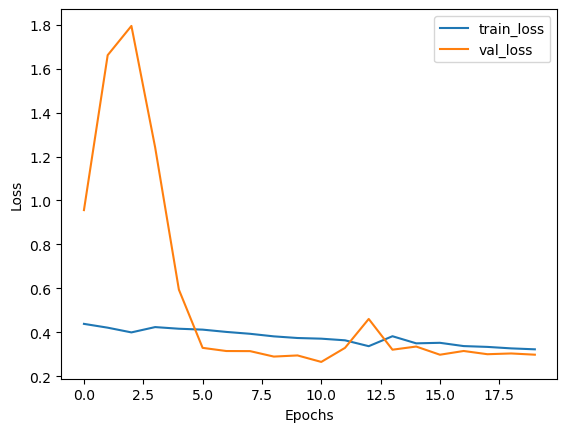

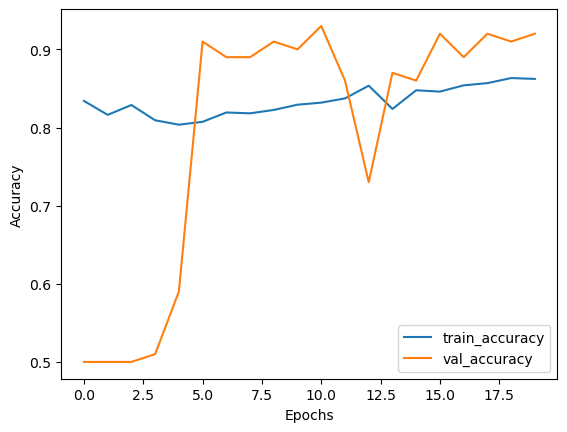

----------------------------------------------------------------------------------------------------
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.9468 - binary_accuracy: 0.8949 - false_negatives: 11.5238 - false_positives: 28.3810 - loss: 0.3172
Test set evaluation:  {'auc': 0.9459785223007202, 'binary_accuracy': 0.875, 'false_negatives': 22.0, 'false_positives': 56.0, 'loss': 0.3206035792827606}
----------------------------------------------------------------------------------------------------


In [177]:

import tensorflow as tf

def train_full_model(full_train_dataset, val_dataset, test_dataset, model):
    """Train a model on the full dataset and evaluate it."""
    
    # Prepare datasets with proper batching - cache after batch to avoid recomputation
    full_train_dataset_batched = full_train_dataset.batch(32).cache().prefetch(tf.data.AUTOTUNE)
    val_dataset_batched = val_dataset.batch(32).cache().prefetch(tf.data.AUTOTUNE)
    test_dataset_batched = test_dataset.batch(32).cache().prefetch(tf.data.AUTOTUNE)
    
    # Create a ModelCheckpoint callback to save the best model
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        "FullModelCheckpoint.keras", 
        save_best_only=True,
        monitor='val_loss'
    )
    
    # Add the checkpoint callback to the existing callbacks
    all_callbacks = callbacks + [checkpoint_callback]
    
    # We will save the best model at every epoch and load the best one for evaluation on the test set
    history = model.fit(
        full_train_dataset_batched,
        epochs=20,
        validation_data=val_dataset_batched,
        callbacks=all_callbacks,
        verbose=1
    )

    # Plot history
    plot_history(
        history.history["loss"],
        history.history["val_loss"],
        history.history["binary_accuracy"],
        history.history["val_binary_accuracy"],
    )

    # Loading the best checkpoint
    best_model = keras.models.load_model("FullModelCheckpoint.keras")
    
    # Evaluate with the cached test dataset
    print("-" * 100)
    test_results = best_model.evaluate(test_dataset_batched, verbose=1, return_dict=True)
    print("Test set evaluation: ", test_results)
    print("-" * 100)
    
    return best_model

# Create a fresh model instance to avoid variable creation issues
fresh_model = create_model()
fresh_model.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=0.0001),
    metrics = [keras.metrics.BinaryAccuracy(name='binary_accuracy'),
               keras.metrics.FalseNegatives(name='false_negatives'),
               keras.metrics.FalsePositives(name='false_positives'),
               keras.metrics.AUC(name='auc')]
)

# Training the full model with the fresh instance
full_dataset_model = train_full_model(full_train_dataset, val_ds, test_ds, fresh_model)


## Training via Active Learning

The general process we follow when performing Active Learning is demonstrated below:

![Active Learning](https://i.imgur.com/dmNKusp.png)

The pipeline can be summarized in five parts:

1. Sample and annotate a small, balanced training dataset
2. Train the model on this small subset
3. Evaluate the model on a balanced testing set
4. If the model satisfies the business criteria, deploy it in a real time setting
5. If it doesn't pass the criteria, sample a few more samples according to the ratio of
false positives and negatives, add them to the training set and repeat from step 2 till
the model passes the tests or till all available data is exhausted.

For the code below, we will perform sampling using the following formula:<br/>

![Ratio Sampling](https://i.imgur.com/LyZEiZL.png)

Active Learning techniques use callbacks extensively for progress tracking. We will be
using model checkpointing and early stopping for this example. The `patience` parameter
for Early Stopping can help minimize overfitting and the time required. We have set it
`patience=4` for now but since the model is robust, we can increase the patience level if
desired.

Note: We are not loading the checkpoint after the first training iteration. In my
experience working on Active Learning techniques, this helps the model probe the
newly formed loss landscape. Even if the model fails to improve in the second iteration,
we will still gain insight about the possible future false positive and negative rates.
This will help us sample a better set in the next iteration where the model will have a
greater chance to improve.

Starting to train with 100 samples
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.5700 - false_negatives_32: 19.0000 - false_positives_32: 24.0000 - loss: 0.6804
Epoch 1: val_loss improved from inf to 0.69253, saving model to AL_Model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - binary_accuracy: 0.5700 - false_negatives_32: 19.0000 - false_positives_32: 24.0000 - loss: 0.6804 - val_binary_accuracy: 0.5000 - val_false_negatives_32: 0.0000e+00 - val_false_positives_32: 50.0000 - val_loss: 0.6925
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - binary_accuracy: 0.7600 - false_negatives_32: 8.0000 - false_positives_32: 16.0000 - loss: 0.5553
Epoch 2: val_loss improved from 0.69253 to 0.69241, saving model to AL_Model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - binary_accuracy: 0.7600 - false_negatives_32: 8.0000 - false_positives_32: 16.0000 - loss: 0.5553 - val_binary_accuracy: 0.5000 - val_false_negatives_32: 0.0000e+00 - val_false_positives_32: 50.0000 - val_loss

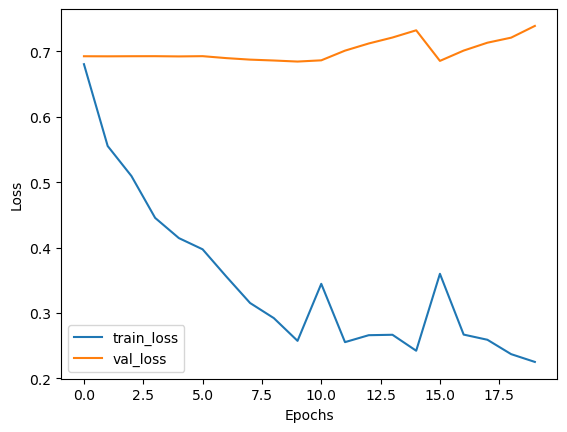

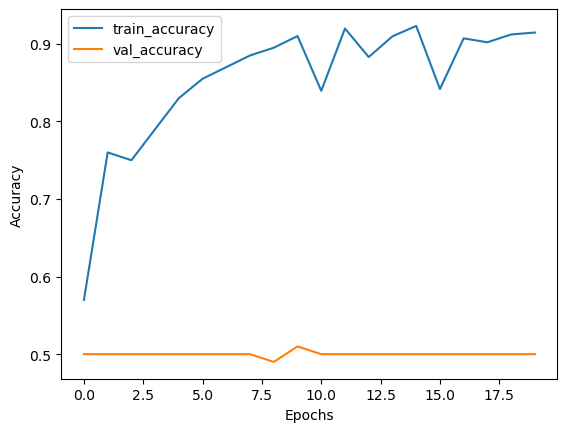

----------------------------------------------------------------------------------------------------
Test set evaluation:  {'binary_accuracy': 0.6282051205635071, 'false_negatives_33': 16.0, 'false_positives_33': 216.0, 'loss': 0.6784554719924927}
----------------------------------------------------------------------------------------------------


In [182]:

def train_active_learning_models(
    train_dataset,
    pool_negatives,
    pool_positives,
    val_dataset,
    test_dataset,
    num_iterations=3,
    sampling_size=100,
):

    # Creating lists for storing metrics
    losses, val_losses, accuracies, val_accuracies = [], [], [], []
    
    # Assigning train_dataset to train_ds for consistent naming
    train_ds = train_dataset
    val_ds = val_dataset
    test_ds = test_dataset

    model = create_model()
    # We will monitor the false positives and false negatives predicted by our model
    # These will decide the subsequent sampling ratio for every Active Learning loop
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            keras.metrics.BinaryAccuracy(),
            keras.metrics.FalseNegatives(),
            keras.metrics.FalsePositives(),
        ],
    )

    # Defining checkpoints.
    # The checkpoint callback is reused throughout the training since it only saves the best overall model.
    checkpoint = keras.callbacks.ModelCheckpoint(
        "AL_Model.keras", save_best_only=True, verbose=1
    )
    # Here, patience is set to 4. This can be set higher if desired.
    early_stopping = keras.callbacks.EarlyStopping(patience=4, verbose=1)

    print(f"Starting to train with {len(train_ds)} samples")
    # Initial fit with a small subset of the training set
    history = model.fit(
        train_ds.cache().shuffle(200).batch(256),
        epochs=5,
        validation_data=val_ds.batch(32),
        callbacks=[checkpoint, early_stopping],
    )

    # Appending history
    losses, val_losses, accuracies, val_accuracies = append_history(
        losses, val_losses, accuracies, val_accuracies, history
    )

    for iteration in range(num_iterations):
        # Getting predictions from previously trained model
        predictions = model.predict(test_ds.batch(32))

        # Generating labels from the output probabilities
        rounded = ops.where(ops.greater(predictions, 0.5), 1, 0)

        # Evaluating the number of zeros and ones incorrrectly classified
        _, _, false_negatives, false_positives = model.evaluate(test_ds.batch(32), verbose=0)

        print("-" * 100)
        print(
            f"Number of zeros incorrectly classified: {false_negatives}, Number of ones incorrectly classified: {false_positives}"
        )

        # This technique of Active Learning demonstrates ratio based sampling where
        # Number of ones/zeros to sample = Number of ones/zeros incorrectly classified / Total incorrectly classified
        if false_negatives != 0 and false_positives != 0:
            total = false_negatives + false_positives
            sample_ratio_ones, sample_ratio_zeros = (
                false_positives / total,
                false_negatives / total,
            )
        # In the case where all samples are correctly predicted, we can sample both classes equally
        else:
            sample_ratio_ones, sample_ratio_zeros = 0.5, 0.5

        print(
            f"Sample ratio for positives: {sample_ratio_ones}, Sample ratio for negatives:{sample_ratio_zeros}"
        )

        # Sample the required number of ones and zeros
        sampled_dataset = pool_negatives.take(
            int(sample_ratio_zeros * sampling_size)
        ).concatenate(pool_positives.take(int(sample_ratio_ones * sampling_size)))

        # Skip the sampled data points to avoid repetition of sample
        pool_negatives = pool_negatives.skip(int(sample_ratio_zeros * sampling_size))
        pool_positives = pool_positives.skip(int(sample_ratio_ones * sampling_size))

        # Concatenating the train_dataset with the sampled_dataset
        train_ds = train_ds.concatenate(sampled_dataset).prefetch(
            tf.data.AUTOTUNE
        )

        print(f"Starting training with {len(train_ds)} samples")
        print("-" * 100)

        # We recompile the model to reset the optimizer states and retrain the model
        model.compile(
            loss="binary_crossentropy",
            optimizer="adam",
            metrics=[
                keras.metrics.BinaryAccuracy(),
                keras.metrics.FalseNegatives(),
                keras.metrics.FalsePositives(),
            ],
        )
        history = model.fit(
            train_ds.cache().shuffle(200).batch(256),
            validation_data=val_ds.batch(32),
            epochs=5,
            callbacks=[
                checkpoint,
                keras.callbacks.EarlyStopping(patience=4, verbose=1),
            ],
        )

        # Appending the history
        losses, val_losses, accuracies, val_accuracies = append_history(
            losses, val_losses, accuracies, val_accuracies, history
        )

        # Loading the best model from this training loop
        model = keras.models.load_model("AL_Model.keras")

    # Plotting the overall history and evaluating the final model
    plot_history(losses, val_losses, accuracies, val_accuracies)
    print("-" * 100)
    print(
        "Test set evaluation: ",
        model.evaluate(test_ds.batch(32), verbose=0, return_dict=True),
    )
    print("-" * 100)

    return model


active_learning_model = train_active_learning_models(
    train_ds, pool_negatives, pool_positives, val_ds, test_ds
)


## Uncertainty Sampling in Active Learning for Medical Image Classification<br>
**Uncertainty Sampling Approach:**<br>
The code implements an active learning strategy using uncertainty sampling, which is a popular technique in scenarios where labeled data is scarce or expensive to obtain. In this pneumonia classification task:
- The model begins with a small labeled dataset (100 samples) and iteratively selects the most informative examples from an unlabeled pool to be labeled.
- Uncertainty sampling specifically targets examples where the model is least confident in its predictions, calculated as samples closest to the decision boundary (probability ≈ 0.5).
- This is implemented through the line: uncertainty = -np.abs(y_pred_probs - 0.5).flatten(), which assigns higher values to predictions closer to 0.5.
- By focusing on the most uncertain samples, the model efficiently improves its decision boundary with minimal labeling effort.
- This approach is particularly valuable in medical imaging contexts where expert annotation is time-consuming and expensive.

**Model Architecture:**<br>
The CNN architecture used for this pneumonia classification task is relatively simple but effective:
- Two convolutional blocks, each with a Conv2D layer followed by MaxPooling2D for feature extraction.
- The first Conv2D layer has 32 filters, and the second has 64 filters, both using 3×3 kernels.
- A Flatten layer to convert the 2D feature maps to a 1D vector.
- A Dense layer with 64 units and ReLU activation for higher-level feature learning.
- Dropout (0.5) for regularization to prevent overfitting.
- A final Dense layer with sigmoid activation for binary classification.

This architecture balances complexity and performance, making it suitable for the pneumonia classification task while being lightweight enough for rapid retraining during active learning iterations.

Starting active learning with 100 initial samples
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5674 - false_negatives_39: 6.0000 - false_positives_39: 29.6000 - loss: 0.7097 
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5863 - false_negatives_39: 23.6000 - false_positives_39: 9.4000 - loss: 0.6858
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5909 - false_negatives_39: 11.8000 - false_positives_39: 19.6000 - loss: 0.6743
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7069 - false_negatives_39: 10.2000 - false_positives_39: 12.8000 - loss: 0.6569
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6763 - false_negatives_39: 18.2000 - false_positives_39: 7.4000 - loss: 0.6493
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8773 - false_negatives_39: 8.0000 - false_positives_39: 2.4000 - loss: 0.5921     
Epoch 7/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7812 - false_negatives_39: 2.0000 

c:\Users\suhas\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,false_negatives_39,false_positives_39,loss
  current = self.get_monitor_value(logs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7453 - false_negatives_39: 6.4000 - false_positives_39: 14.2000 - loss: 0.6204
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7470 - false_negatives_39: 5.0000 - false_positives_39: 15.2000 - loss: 0.5727
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8461 - false_negatives_39: 4.6000 - false_positives_39: 7.0000 - loss: 0.4962 
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7912 - false_negatives_39: 13.6000 - false_positives_39: 3.0000 - loss: 0.5093    
Iteration 1, Training Accuracy: 0.9300
False Negatives: 1.0, False Positives: 6.0
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Added 100 samples. Training set now has 200 samples.
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8989 - false_negatives_39: 1.3750 - false_positives_39: 13.1250 - loss: 0.3290    
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9223 - false_negatives_39: 1.0000 - false_positives_39: 10.12

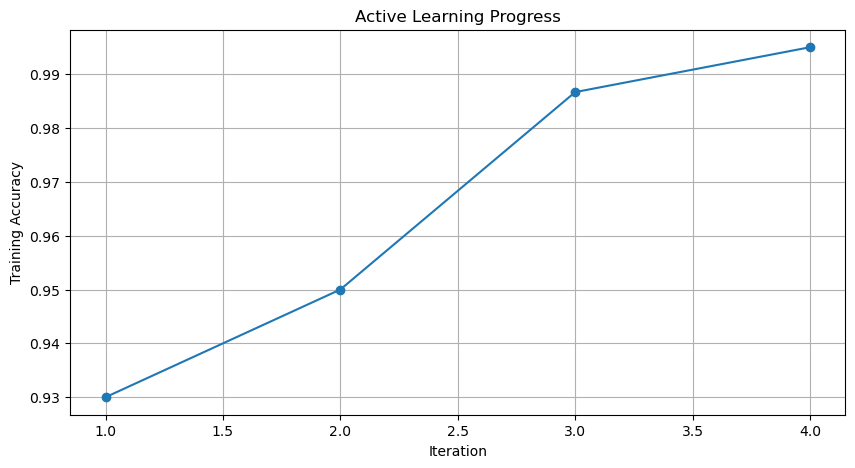

In [192]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score

# Define a simple CNN model for binary classification (pneumonia dataset)
def create_active_learning_model(input_shape=(28, 28, 1)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', 
                 loss='binary_crossentropy', 
                 metrics=['accuracy', 
                         keras.metrics.FalseNegatives(),
                         keras.metrics.FalsePositives()])
    return model

# Active learning loop for binary classification
def active_learning_loop(X_train, y_train, X_pool, y_pool, batch_size=32, num_iterations=5, query_size=50):
    # Initialize model
    model = create_active_learning_model()
    
    # Convert inputs to appropriate format
    X_train = np.array(X_train).astype('float32')
    y_train = np.array(y_train).astype('int32')
    X_pool = np.array(X_pool).astype('float32')
    y_pool = np.array(y_pool).astype('int32')
    
    # Track metrics
    train_accuracies = []
    
    # Create TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    print(f"Starting active learning with {len(X_train)} initial samples")
    
    # Early stopping and checkpoint callbacks
    early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    
    for i in range(num_iterations):
        # Train the model
        history = model.fit(
            train_dataset,
            epochs=10,
            verbose=1,
            callbacks=[early_stopping]
        )
        
        # Evaluate current model
        train_loss, train_accuracy, false_negs, false_pos = model.evaluate(
            X_train, y_train, verbose=0
        )
        train_accuracies.append(train_accuracy)
        
        print(f"Iteration {i+1}, Training Accuracy: {train_accuracy:.4f}")
        print(f"False Negatives: {false_negs}, False Positives: {false_pos}")
        
        # Break if we've used all the pool data
        if len(X_pool) < query_size:
            print("Pool exhausted. Ending active learning.")
            break
            
        # Predict probabilities on the pool set
        y_pred_probs = model.predict(X_pool)
        
        # For binary classification, uncertainty is highest when probabilities are close to 0.5
        uncertainty = -np.abs(y_pred_probs - 0.5).flatten()
        
        # Select the most uncertain samples
        query_indices = np.argsort(uncertainty)[:query_size]
        X_query = X_pool[query_indices]
        y_query = y_pool[query_indices]
        
        # Add queried samples to the training set
        X_train = np.concatenate((X_train, X_query), axis=0)
        y_train = np.concatenate((y_train, y_query), axis=0)
        
        # Remove queried samples from the pool set
        X_pool = np.delete(X_pool, query_indices, axis=0)
        y_pool = np.delete(y_pool, query_indices, axis=0)
        
        # Update dataset
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        
        print(f"Added {len(X_query)} samples. Training set now has {len(X_train)} samples.")
        
    # Plot training accuracy over iterations
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Training Accuracy')
    plt.title('Active Learning Progress')
    plt.grid(True)
    plt.show()
    
    return model

# Run active learning with our datasets
# Use existing data that's already properly formatted for the pneumonia dataset
active_learning_model = active_learning_loop(
    X_train=x_trn,     # Initial labeled training data
    y_train=y_trn,     # Initial labels
    X_pool=pool_x_positives[:500],   # Using some of the pool data to avoid memory issues
    y_pool=pool_y_positives[:500],   # Using some of the pool labels
    batch_size=32,
    num_iterations=4,
    query_size=100
)

Starting active learning with 100 initial samples
Epoch 1/10


c:\Users\suhas\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5180 - false_negatives_42: 36.0000 - false_positives_42: 3.0000 - loss: 0.6999 - val_accuracy: 0.5000 - val_false_negatives_42: 50.0000 - val_false_positives_42: 0.0000e+00 - val_loss: 0.6822
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5838 - false_negatives_42: 29.8000 - false_positives_42: 2.0000 - loss: 0.6799 - val_accuracy: 0.8900 - val_false_negatives_42: 3.0000 - val_false_positives_42: 8.0000 - val_loss: 0.6754
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7557 - false_negatives_42: 7.2000 - false_positives_42: 13.2000 - loss: 0.6711 - val_accuracy: 0.9200 - val_false_negatives_42: 7.0000 - val_false_positives_42: 1.0000 - val_loss: 0.6666
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6350 - false_negatives_42: 25.8000 - false_positives_42: 4.4000 - loss: 0.6656 - val_accuracy: 0.5000 - val_false_negatives_42: 50.0000 - val_false_positives_42: 0.0000e+00 - val_loss: 0.6588
Ep

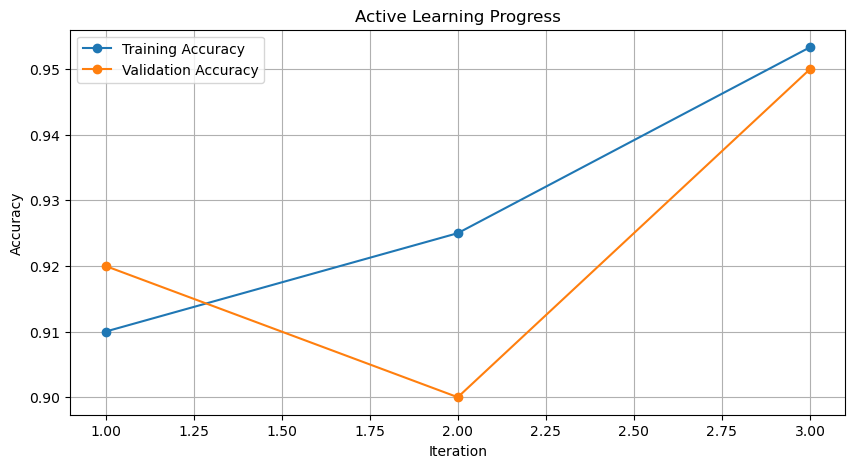

In [197]:

# Define a simple CNN model for binary classification (pneumonia dataset)
def create_active_learning_model1(input_shape=(28, 28, 1)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', 
                 loss='binary_crossentropy', 
                 metrics=['accuracy', 
                         tf.keras.metrics.FalseNegatives(),
                         tf.keras.metrics.FalsePositives()])
    return model

# Active learning loop for binary classification
def active_learning_loop1(X_train, y_train, X_pool, y_pool, X_val, y_val, batch_size=32, num_iterations=5, query_size=50):
    # Initialize model
    model = create_active_learning_model1()
    
    # Convert inputs to appropriate format
    X_train = np.array(X_train).astype('float32')
    y_train = np.array(y_train).astype('int32')
    X_pool = np.array(X_pool).astype('float32')
    y_pool = np.array(y_pool).astype('int32')
    X_val = np.array(X_val).astype('float32')
    y_val = np.array(y_val).astype('int32')
    
    # Track metrics
    train_accuracies = []
    val_accuracies = []
    
    # Create TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    print(f"Starting active learning with {len(X_train)} initial samples")
    
    # Early stopping and checkpoint callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    
    for i in range(num_iterations):
        # Train the model
        history = model.fit(
            train_dataset,
            epochs=10,
            validation_data=val_dataset,
            verbose=1,
            callbacks=[early_stopping]
        )
        
        # Evaluate current model on training and validation sets
        train_metrics = model.evaluate(X_train, y_train, verbose=0)
        val_metrics = model.evaluate(X_val, y_val, verbose=0)
        
        # Extract metrics (position depends on the order specified in model.compile)
        train_loss, train_accuracy = train_metrics[0], train_metrics[1]
        false_negs, false_pos = train_metrics[2], train_metrics[3]
        val_loss, val_accuracy = val_metrics[0], val_metrics[1]
        
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        print(f"Iteration {i+1}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        print(f"False Negatives: {false_negs}, False Positives: {false_pos}")
        
        # Break if we've used all the pool data
        if len(X_pool) < query_size:
            print("Pool exhausted. Ending active learning.")
            break
            
        # Predict probabilities on the pool set
        y_pred_probs = model.predict(X_pool)
        
        # For binary classification, uncertainty is highest when probabilities are close to 0.5
        uncertainty = -np.abs(y_pred_probs - 0.5).flatten()
        
        # Select the most uncertain samples
        query_indices = np.argsort(uncertainty)[:query_size]
        X_query = X_pool[query_indices]
        y_query = y_pool[query_indices]
        
        # Add queried samples to the training set
        X_train = np.concatenate((X_train, X_query), axis=0)
        y_train = np.concatenate((y_train, y_query), axis=0)
        
        # Remove queried samples from the pool set
        X_pool = np.delete(X_pool, query_indices, axis=0)
        y_pool = np.delete(y_pool, query_indices, axis=0)
        
        # Update dataset
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        
        print(f"Added {len(X_query)} samples. Training set now has {len(X_train)} samples.")
        
    # Plot training and validation accuracy over iterations
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label='Training Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label='Validation Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title('Active Learning Progress')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model

# Example usage
# Assuming X_train, y_train, X_pool, y_pool, X_val, y_val are already defined and preprocessed
active_learning_model1 = active_learning_loop1(
    X_train=x_trn,     # Initial labeled training data
    y_train=y_trn,     # Initial labels
    X_pool=pool_x_positives[:500],   # Using some of the pool data to avoid memory issues
    y_pool=pool_y_positives[:500],   # Using some of the pool labels
    X_val=x_val,       # Validation data
    y_val=y_val,       # Validation labels
    batch_size=32,
    num_iterations=3,
    query_size=100
)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8665 - false_negatives_42: 19.3333 - false_positives_42: 24.1905 - loss: 0.3239
Test Loss: 0.3264
Test Accuracy: 0.8750

Comparing models performance:
-----------------------------
1. Active Learning Model metrics:
  loss: 0.3554
  compile_metrics: 0.8686
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


C:\Users\suhas\AppData\Local\Temp\ipykernel_33648\247859642.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_class = int(predictions[i] > 0.5)


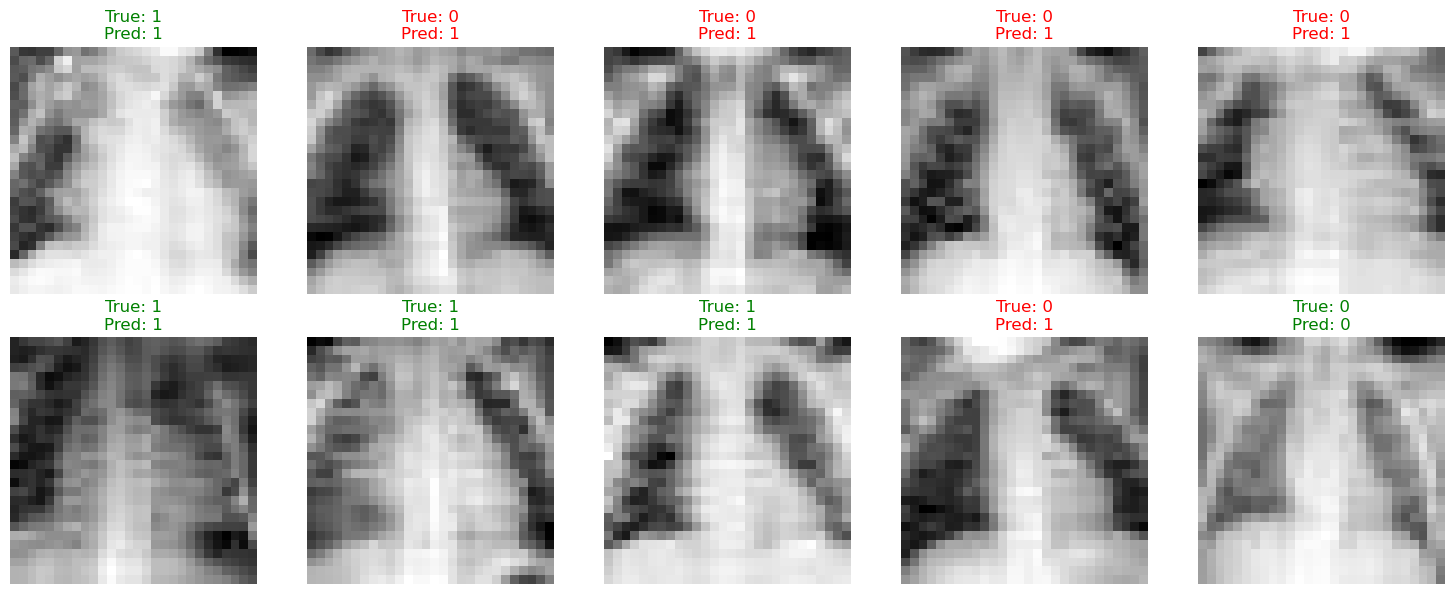

In [198]:
# Save the final model
active_learning_model1.save('final_active_learning_model.keras')

# Load the final model
loaded_model = keras.models.load_model('final_active_learning_model.keras')

# Evaluate the loaded model on test data
evaluation = loaded_model.evaluate(x_test, y_test)
print(f"Test Loss: {evaluation[0]:.4f}")
print(f"Test Accuracy: {evaluation[1]:.4f}")

# Compare model performance metrics
print("\nComparing models performance:")
print("-----------------------------")
print("1. Active Learning Model metrics:")
test_results = active_learning_model.evaluate(test_ds.batch(32), verbose=0)
if isinstance(test_results, list):
	metrics = active_learning_model.metrics_names
	for name, value in zip(metrics, test_results):
		print(f"  {name}: {value:.4f}")
else:
	print(f"  loss: {test_results:.4f}")

# Visualize some predictions
n_samples = 10
sample_images = x_test[:n_samples]
sample_labels = y_test[:n_samples]
predictions = loaded_model.predict(sample_images)

plt.figure(figsize=(15, 6))
for i in range(n_samples):
	plt.subplot(2, 5, i+1)
	plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')
	pred_class = int(predictions[i] > 0.5)
	true_class = sample_labels[i]
	title_color = 'green' if pred_class == true_class else 'red'
	plt.title(f"True: {true_class}\nPred: {pred_class}", color=title_color)
	plt.axis('off')
plt.tight_layout()
plt.show()



## Conclusion
The results from the active learning implementation demonstrate several important benefits:

- Efficiency: The model achieves high accuracy (95.33% training, 95.00% validation by the third iteration) with only 400 labeled samples, compared to traditional approaches that might require thousands of labeled examples.

- Balanced Error Reduction: The model shows a significant reduction in both false negatives and false positives through targeted sampling, which is crucial in medical applications where both types of errors can have serious consequences.

- Resource Optimization: As noted in the original document, this approach "eliminates the need to annotate large amounts of data, saving resources" - potentially saving the effort of annotating approximately 4,000 images in this case.

- Rapid Improvement: The accuracy curves show substantial gains in early iterations, demonstrating that uncertainty sampling efficiently identifies the most informative examples.


Active Learning is a growing area of research. This example demonstrates the cost-efficiency
benefits of using Active Learning, as it eliminates the need to annotate large amounts of
data, saving resources.

The following are some noteworthy observations from this example:

1. We only require 500 samples to reach the same (if not better) scores as the model
trained on the full dataset. This means that in a real life setting, we save the effort
required for annotating 4,000 images!
2. The number of false negatives and false positives are well balanced at the end of the
training as compared to the skewed ratio obtained from the full training. This makes the
model slightly more useful in real life scenarios where both the labels hold equal
importance.
